Чернобаев А.А. М8О-114М-23

In [137]:
import tensorflow as tf

Импортируем книгу из Проекта Гутерберг - Библия

In [138]:
file = tf.keras.utils.get_file('/home/rugewit/Programming/ML-2sem/ai-lab-m3-generative-networks-marmot/data/bible.txt', 'https://gutenberg.org/cache/epub/10/pg10.txt')

file_text = open(file, 'rb').read().decode(encoding = 'utf-8') 

In [139]:
print(file_text[:1000])

The Project Gutenberg eBook of The King James Version of the Bible
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The King James Version of the Bible

Release date: August 1, 1989 [eBook #10]
                Most recently updated: April 6, 2024

Language: English



*** START OF THE PROJECT GUTENBERG EBOOK THE KING JAMES VERSION OF THE BIBLE ***
The Old Testament of the King James Version of the Bible
The First Book of Moses: Called Genesis
The Second Book of Moses: Called Exodus
The Third Book of Moses: Called Leviticus
The Fourth Book of Moses: Called Number


Преобразование ids в char и обратно

In [140]:
unique_chars = sorted(set(file_text))

chars_to_ids = tf.keras.layers.StringLookup(vocabulary = list(unique_chars), mask_token = None)
ids_to_chars = tf.keras.layers.StringLookup(vocabulary = chars_to_ids.get_vocabulary(), invert = True, mask_token = None)

In [141]:
def ids_to_text(ids):
  return tf.strings.reduce_join(ids_to_chars(ids), axis=-1)

Преобразование датасета

In [142]:
full_ids = chars_to_ids(tf.strings.unicode_split(file_text, 'UTF-8'))
ids_full_dataset = tf.data.Dataset.from_tensor_slices(full_ids)

In [143]:
seq_length = 100 # длина последовательности

sequences = ids_full_dataset.batch(seq_length + 1, drop_remainder=True) 

Преобразование датасета в Input и Target

In [144]:
def split_into_x_y(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [145]:
dataset_xy = sequences.map(split_into_x_y)

Создаем датасет

In [146]:
BATCH_SIZE = 256

BUFFER_SIZE = 10000

dataset = (
    dataset_xy
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)) 

In [147]:
vocab_size = len(chars_to_ids.get_vocabulary())

embedding_dim = 64

rnn_units = 64

In [148]:
def build_chars_simple_rnn_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=(batch_size, None)),        
    tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [149]:
model = build_chars_simple_rnn_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (256, None, 64)           5760      
                                                                 
 simple_rnn_9 (SimpleRNN)    (256, None, 64)           8256      
                                                                 
 dense_16 (Dense)            (256, None, 90)           5850      
                                                                 
Total params: 19,866
Trainable params: 19,866
Non-trainable params: 0
_________________________________________________________________


In [150]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [151]:
model.compile(optimizer='adam', loss=loss)

In [152]:
EPOCHS = 10
h = model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
172/172 [==============================] - 13s 61ms/step - loss: 3.0049
Epoch 2/10
172/172 [==============================] - 11s 56ms/step - loss: 2.1649
Epoch 3/10
172/172 [==============================] - 11s 57ms/step - loss: 1.9663
Epoch 4/10
172/172 [==============================] - 10s 55ms/step - loss: 1.8602
Epoch 5/10
172/172 [==============================] - 10s 54ms/step - loss: 1.7853
Epoch 6/10
172/172 [==============================] - 11s 59ms/step - loss: 1.7299
Epoch 7/10
172/172 [==============================] - 10s 54ms/step - loss: 1.6883
Epoch 8/10
172/172 [==============================] - 11s 57ms/step - loss: 1.6558
Epoch 9/10
172/172 [==============================] - 10s 54ms/step - loss: 1.6292
Epoch 10/10
172/172 [==============================] - 10s 54ms/step - loss: 1.6087


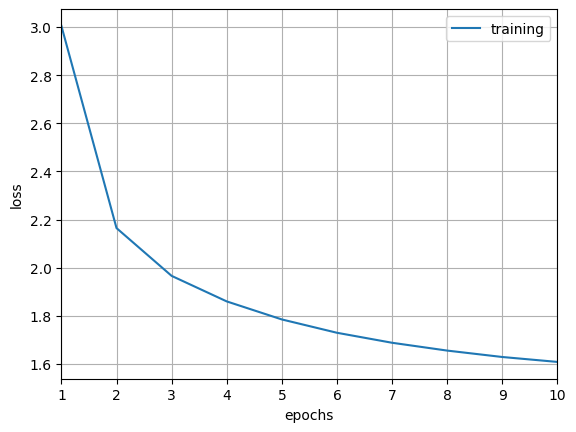

In [153]:
import matplotlib.pyplot as plt

x_axis = range(1, EPOCHS + 1)
plt.plot(x_axis, h.history['loss'], label='training')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim((1, EPOCHS))
plt.legend()
plt.show()

In [154]:
model.save_weights('chars-simle-rnn-weights.h5')

In [155]:
simle_rnn_text_gen = build_chars_simple_rnn_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
simle_rnn_text_gen.load_weights('chars-simle-rnn-weights.h5')
simle_rnn_text_gen.build(tf.TensorShape([1, None]))

In [156]:
def generate_text(model, start_string, temperature = 1.0, prediction_length = 1000):
    input_eval = [chars_to_ids(s) for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
   
    text_generated = []

    model.reset_states()
    for _ in range(prediction_length):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(ids_to_chars(predicted_id))

    return (start_string + tf.strings.join(text_generated).numpy().decode('utf-8'))

In [157]:
print(generate_text(simle_rnn_text_gen, start_string=u"Heaven", temperature = 0.8, prediction_length = 500))

Heaven his and deenses of Philis saiveles of the your bomeitenglact there of that him.

11:8 But the staber of hath that secve, tnom the Goked anay that he wan of the given that orer thit shall with eviled, but the broldin lish the ry.

4:18 Septind:
and dierd a goth therest theth which thou God, and down it thou the tigaine, ye lot, jedurding fearl, and the phildres, grod, for the LORD peary every aboow, and thy man shall lovesteme, and hand of the plethes, and a set me the gon with the man whic


In [158]:
def build_chars_lstm_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=(batch_size, None)),        
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [159]:
lstm_batch = 64

BUFFER_SIZE = 10000

dataset_lstm = (
    dataset_xy
    .shuffle(BUFFER_SIZE)
    .batch(lstm_batch, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)) 

In [160]:
lstm_embedding_size = 256
lstm_rnn_units = 512

In [161]:
lstm_model = build_chars_lstm_model(vocab_size, lstm_embedding_size, lstm_rnn_units, lstm_batch)

In [162]:
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (64, None, 256)           23040     
                                                                 
 lstm_7 (LSTM)               (64, None, 512)           1574912   
                                                                 
 dense_18 (Dense)            (64, None, 90)            46170     
                                                                 
Total params: 1,644,122
Trainable params: 1,644,122
Non-trainable params: 0
_________________________________________________________________


In [163]:
lstm_model.compile(optimizer='adam', loss=loss)
EPOCHS = 10
h = lstm_model.fit(dataset_lstm, epochs=EPOCHS)

Epoch 1/10


688/688 [==============================] - 11s 13ms/step - loss: 1.8857
Epoch 2/10
688/688 [==============================] - 9s 11ms/step - loss: 1.3277
Epoch 3/10
688/688 [==============================] - 8s 11ms/step - loss: 1.2030
Epoch 4/10
688/688 [==============================] - 8s 10ms/step - loss: 1.1429
Epoch 5/10
688/688 [==============================] - 9s 11ms/step - loss: 1.1063
Epoch 6/10
688/688 [==============================] - 8s 10ms/step - loss: 1.0797
Epoch 7/10
688/688 [==============================] - 8s 10ms/step - loss: 1.0590
Epoch 8/10
688/688 [==============================] - 8s 10ms/step - loss: 1.0423
Epoch 9/10
688/688 [==============================] - 8s 11ms/step - loss: 1.0286
Epoch 10/10
688/688 [==============================] - 8s 11ms/step - loss: 1.0170


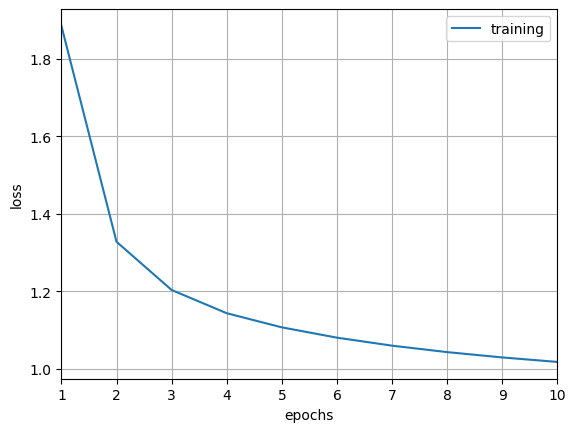

In [164]:
x_axis = range(1, EPOCHS + 1)
plt.plot(x_axis, h.history['loss'], label='training')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim((1, EPOCHS))
plt.legend()
plt.show()

In [165]:
lstm_model.save_weights('chars-lstm-weights.h5')

lstm_text_gen = build_chars_lstm_model(vocab_size, lstm_embedding_size, lstm_rnn_units, batch_size=1)
lstm_text_gen.load_weights('chars-lstm-weights.h5')
lstm_text_gen.build(tf.TensorShape([1, None]))

In [166]:
print(generate_text(lstm_text_gen, start_string=u"Heaven", temperature = 0.8, prediction_length = 500))

Heaveng the river of
Babylon: and if a man do we laid up to the innorth the
power of all nd the fathers hald been collemies or a falter with
strength winds; and she was perpetual and grace, and
he was the shield, he shall not reserve tranks in the blood,
which he rewarded me.

13:7 The LORD is the Egyptians, who is alones.

109:30 He breaketh bardself, and a fiery furnace of blaspheme, and priests and
unrighteousness: who then saith, I was made in the midst of the nations.

1:17 For whosoe
